# Homework 2
## Part 1: A/B Hypothesis testing

| | ad clicks | total views |
|---|---|---|
|A| 500 | 1000 |
|B| 550 | 1000 |

Perform a hypothesis test using the two-proportion z-value test [See the "pooled" version from the table here](https://en.wikipedia.org/wiki/Test_statistic) statistic at both the 5% and 1% signficance levels.

Begin by formulating and writing down your null hypothesis, then compute the Z value for this trial, and its associated p-value.
 Note: the Z value you compute is assumed to be distributed according to the standard normal distribution (mean = 0, variance = 1).  We'll consider the "1-sided" p-value which meaures the probability of a sample having a Z value that is more extreme in only one tail (to get the 2-sided value, you'd just multiply by 2).  
 
**What can you conclude?**  
**Answer**

*Null Hypothesis(H0): P(A) - P(B) = 0 , ad A and ad B have the same click rate  
Alternative Hypothesis(H1): P(B) >  P(A), ad B has higher click rate*

In [7]:
import math
import scipy
from scipy.stats import norm
#data
clicks_A = 500
views_A = 1000
clicks_B = 550
views_B = 1000
#click rate
pA = clicks_A / views_A
pB = clicks_B / views_B
# pooled proportion
p = (clicks_A + clicks_B) / (views_A + views_B)
# standard error
se = math.sqrt(p * (1 - p) * (1/views_A + 1/views_B))
# Z
z = (pB - pA) / se
#one-sided p-value
pvalue = 1 - norm.cdf(z)

print(f"Z = {z:.4f}")
print(f"p-value = {pvalue:.4f}")



Z = 2.2389
p-value = 0.0126


 Conculison:  
 0.0126 < 0.05  
 At the 5% significance level，there is statistical significance that we reject the null hypothesis, and accept the althernative hypothsis that ad B performs better than ad A.

## Part 2: Regression of real estate data

For this problem, you will analyze SLC real estate data. The dataset contains multiple listing service (MLS) real estate transactions for houses sold in 2015-16 in zip code 84103 (SLC avenues neighborhod [Google Map](https://www.google.com/maps/place/Salt+Lake+City,+UT+84103/@40.8030372,-111.8957957,12z/data=!3m1!4b1!4m5!3m4!1s0x87525f672006dded:0x311e638d9a1a2de5!8m2!3d40.810506!4d-111.8449346)). We are primarily interested in regressing the `SoldPrice` on the house attributes (property size, house size, number of bedrooms, etc...). 


### Task 1: Import the data 

Use the pandas.read_csv() function to import the dataset. The data is contained in two files: [realEstate1.csv](realEstate1.csv) and [realEstate2.csv](realEstate2.csv). After you import these files separately, concatenate them into one big dataframe. This pandas dataframe will be used for data exploration and linear regression. 
 
 

In [13]:
import pandas as pd
#read in two csv
df1 = pd.read_csv("realEstate1.csv")
df2 = pd.read_csv("realEstate2.csv")
#concatenate
df = pd.concat([df1,df2])
#examine concatenate
df.head()
df.tail() 



,ListNo,Access,AdditInfo,Acres,ListAgt,AirType,Amenities,Area,BackDim,Basemnt,...,WinEvp1,WinEvp2,WinEvp3,WinEvp4,Window,WithDrDt,YearBlt,Zip,Zoning,LastMod
143,1277128,Concrete,NaN,0.28,Liz Slager,Central Air; Electric,Cable Tv Wired; Electric Dryer Hookup; Exercis...,101,0.0,Partial; Walkout,...,0,0,0,0,Blinds; Full,00/00/0000,1978,84103,RES,10/06/2015
144,1265274,Concrete,NaN,0.01,PATRICK WISCOMBE,Central Air; Electric,Electric Dryer Hookup; Exercise Room; Gas Drye...,101,0.0,None/Crawl Space,...,0,0,0,0,Full; Shades,00/00/0000,1979,84103,NaN,05/24/2016
145,1241781,Concrete,NaN,0.00,Jacqui Johnston,Central Air; Electric,Exercise Room; Swimming Pool,101,0.0,None/Crawl Space,...,0,0,0,0,Draperies,00/00/0000,1976,84103,CONDO,10/29/2015
146,1238399,NaN,NaN,0.07,Grady Kohler,Central Air; Electric,Cable Tv Available; Electric Dryer Hookup,101,0.0,None/Crawl Space,...,0,0,0,0,NaN,00/00/0000,1886,84103,NaN,09/11/2015
147,1222911,Common Drive; Concrete,NaN,0.01,Jennifer Beck,Central Air; Electric; Heat Pump,Cable Tv Wired; Clubhouse; Electric Dryer Hook...,101,0.0,None/Crawl Space,...,0,0,0,0,Blinds; Full,00/00/0000,1981,84103,R-1,10/01/2015



### Task 2: Clean the data 

+ There are 206 different variables associated with each of the 348 houses in this dataset. Skim them and try to get a rough understanding of what information this dataset contains. If you've never seen a real estate listing before, you might take a look at one on [this](http://www.utahrealestate.com/) website to get a better sense of the meanings of the column headers in the dataset.  

+ Only keep houses with List Price between 200,000 and 1,000,000 dollars. This is an arbitrary choice and we realize that some of you are high rollers, but for our purposes we'll consider the others as outliers. Also, this data is ~10 years old.  There DID use to be houses available for under $200k!

+ Remove columns that you don't think contribute to the value of the house. This is a personal decision - what attributes of a house are important to you? You should at least keep the following variables since the questions below will use them: ['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude', 'LstPrice', 'Patio', 'PkgSpacs', 'PropType', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt'] 

+ Check the datatypes and convert any numbers that were read as strings to numerical values. (Hint: You can use [str.replace()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.replace.html) to work with strings.) If there are any categorical values you're interested in, then you should convert them to numerical values as we saw in the notes (the `get_dummies` function may help). In particular, convert 'TotSqf' to an integer and add a column titled Prop_Type_num that is 0 if i-th listing is a condo or townhouse, or 1 if i-th listing is a single family house

+ Remove the listings with erroneous 'Longitude' (one has Longitude = 0) and 'Taxes' values (at least two have unreasonably large values).




In [35]:
#bool index to filter
pd.set_option('display.float_format', '{:,.0f}'.format)
df = df[(df["LstPrice"] >= 200000)& (df["LstPrice"] < 1000000)]
#important columns
columns = ['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude',
            'LstPrice', 'Patio', 'PkgSpacs', 'PropType', 'SoldPrice',
            'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']
df = df[columns]
df.head()
#numbers that should not read as string--totsqf
df['TotSqf'] = df['TotSqf'].replace('r[^\d.]', '', regex=True).astype(float).astype(int)
df.head()
# map to convert propType
df["propTypeNum"] = df["PropType"].map({"Condo" : 0, "Townhouse" : 0, "Single Family" : 1})
df.head()
# error data
df.describe()
df = df[df['Longitude'] != 0]
df = df[df['Taxes'] < 100000]
df.describe()




<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
/var/folders/ry/vysnt2bs7cq9hdgf64w_yw7h0000gn/T/ipykernel_33937/309370117.py:11: SyntaxWarning: invalid escape sequence '\d'
  df['TotSqf'] = df['TotSqf'].replace('r[^\d.]', '', regex=True).astype(float).astype(int)


,Acres,Deck,GaragCap,Latitude,Longitude,LstPrice,Patio,PkgSpacs,SoldPrice,Taxes,TotBed,TotBth,TotSqf,YearBlt,propTypeNum
count,260,260,260,260,260,260,260,260,260,260,260,260,260,260,260
mean,0,1,1,41,-112,"460,980",1,1,"448,461","3,382",3,3,"2,467","1,941",1
std,0,1,1,0,0,"197,622",3,2,"187,904","6,195",1,1,"1,212",36,0
min,0,0,0,41,-112,"200,000",0,0,"190,000",1,1,0,844,"1,852",0
25%,0,0,0,41,-112,"309,750",0,0,"307,000","1,850",2,2,"1,543","1,908",1
50%,0,1,1,41,-112,"409,500",1,0,"400,000","2,424",3,2,"2,202","1,937",1
75%,0,1,2,41,-112,"586,000",1,2,"561,625","3,806",4,3,"3,013","1,976",1
max,1,16,5,41,-112,"999,900",54,8,"980,000","99,242",8,7,"7,508","2,015",1


### Task 3: Exploratory data analysis 

+ Explore the dataset. Write a short description of the dataset describing the number of items, the number of variables and check to see if the values are reasonable. 

+ Make a bar chart showing the breakdown of the different types of houses (single family, townhouse, condo). 

+ Compute the correlation matrix and use a heat map to visualize the correlation coefficients. 
    - Use a diverging color scale from -1 to +1 (see vmin and vmax parameters for [pcolor](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.pcolor.html)
    - Show a legend (colorbar)
    - Make sure the proper labels are visible and readable (see [xticks](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.xticks.html) and the corresponding [yticks](https://matplotlib.org/devdocs/api/_as_gen/matplotlib.pyplot.yticks.html).

+ Make a scatter plot matrix to visualize the correlations. For the plot, only use a subset of the columns: ['Acres', 'LstPrice', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']. Determine which columns have strong correlations. 

+ Describing your findings. 


260 records and measured 16 variables


Text(0, 0.5, 'amount')

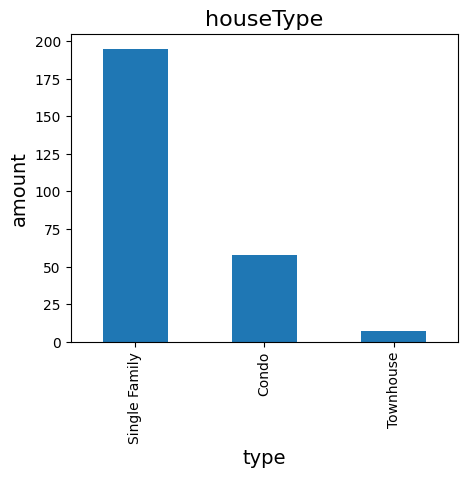

In [38]:
print(f"{df.shape[0]} records and measured {df.shape[1]} variables")
df.describe()

import matplotlib.pyplot as plt
%matplotlib inline
#data: house type
counts = df['PropType'].value_counts()
#figure and ax
fig = plt.figure(figsize=(5,4))
houseType = fig.add_subplot(1,1,1)
#plot title x y
counts.plot(kind='bar', ax=houseType)
houseType.set_title('houseType', fontsize=16)
houseType.set_xlabel('type', fontsize=14)
houseType.set_ylabel('amount', fontsize=14)



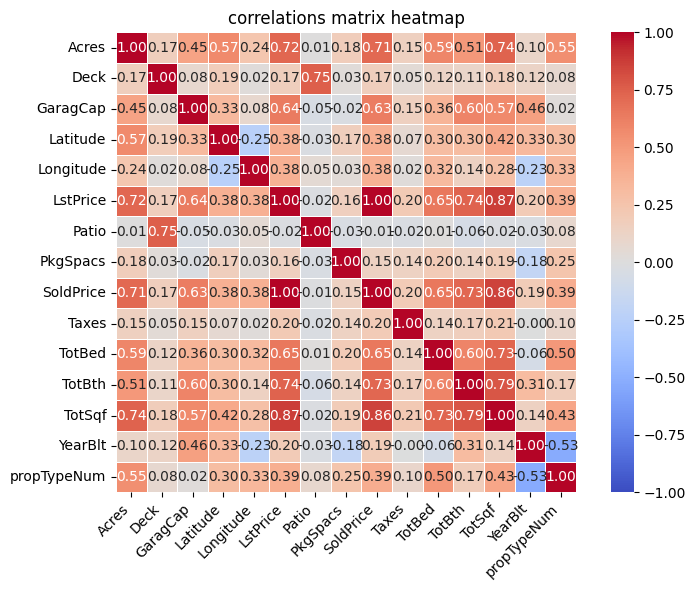

In [42]:
import seaborn as sns
num_cols = df.select_dtypes(include=['number']).columns
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            cbar=True, square=True, fmt=".2f", linewidths=0.5)
plt.title('correlations matrix heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


 LstPrice, SoldPrice, TotSqf, and TotBth all show correlations of 0.65-0.87 with each other. This makes sense because larger homes with more bathrooms typically cost more.  
 Acres having only moderate correlation (0.45-0.57) with other size measures, suggesting lot size and house size don't always go together.

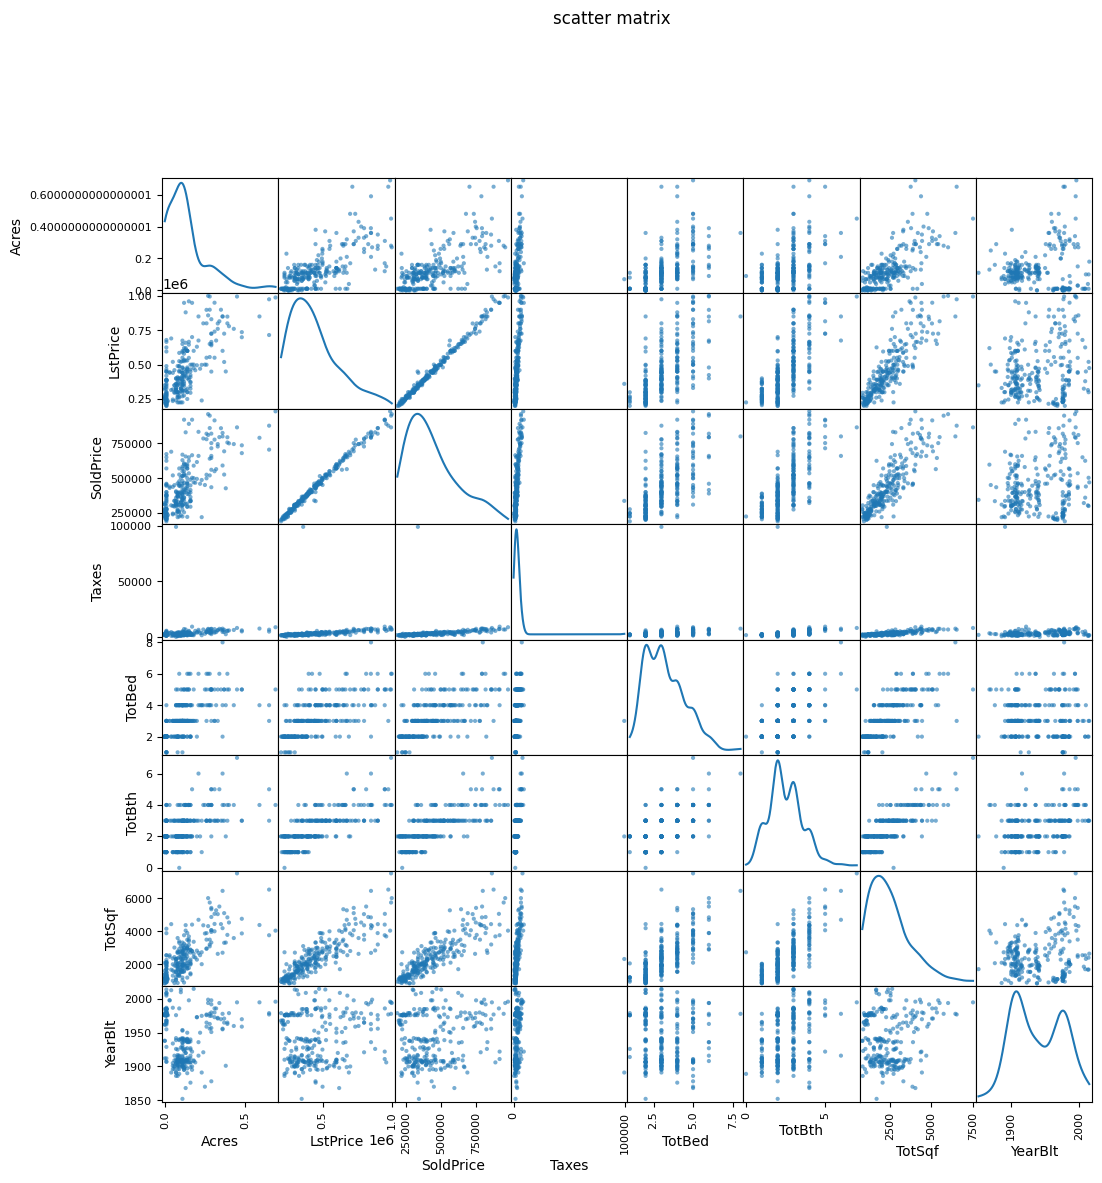

In [43]:
from pandas.plotting import scatter_matrix
#subset
subset_cols = ['Acres', 'LstPrice', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']
scatter_matrix(df[subset_cols], figsize=(12,12), diagonal='kde', alpha=0.6)
plt.suptitle('scatter matrix', y=1.02)
plt.show()

### Task 4: Geospatial plot

Two of the variables are the latitude and longitude of each listing. Salt Lake City is on this nice east-west, north south grid, so even a simple plot of lat and long makes sense. Create a scatterplot of these two variables. Use color to indicate the price of the house. How does the price depend on the house location?

Bonus: If you can, overlay the scatterplot on a map of the city. (This is challenging, and we didn't teach you how to do it, so you should do the other parts of the assignment first.)

What can you say about the relation between the location and the house price?

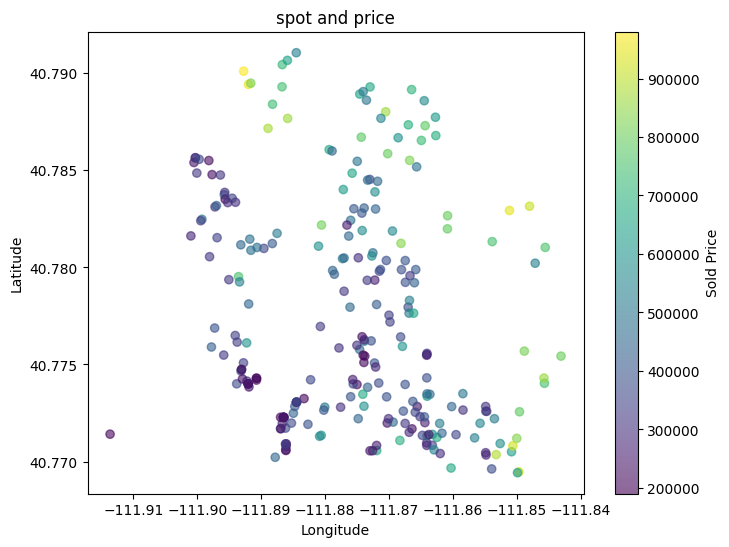

In [45]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['Longitude'], df['Latitude'], c=df['SoldPrice'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Sold Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('spot and price')
plt.show()

More expensive homes (yellow/green dots) tend to cluster on the right side of the map, which corresponds to more eastern longitudes (closer to -111.85). Cheaper homes (purple/blue dots) are more common on the left side (closer to -111.91).

This implies a spatial trend where properties located more toward the east (possibly closer to more desirable neighborhoods, parks, amenities, or schools) tend to sell for higher prices.



### Task 5: Simple  Linear Regression 

Use the 'ols' function from the [statsmodels](http://www.statsmodels.org/stable/index.html) package to regress the Sold price on some of the other variables. Your model should be of the form `Sold Price = beta_0 + beta_1 * x`, where x is one of the other variables. 

You'll find that the best predictor of sold price is the list price. Report the R-squared value for this model (`SoldPrice ~ LstPrice`) and give an interpretation for its meaning. Also give an interpretation of `beta_1` for this model. Make a plot of list price vs. sold price and overlay the prediction coming from your regression model. 

In [47]:
import statsmodels.api as sm

X = df[['LstPrice', 'Taxes', 'TotSqf']]  
X = sm.add_constant(X)                   
y = df['SoldPrice']             
#fit
model = sm.OLS(y, X).fit()               
print(model.summary())                 

                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     8685.
Date:                Sat, 31 May 2025   Prob (F-statistic):          3.80e-257
Time:                        22:09:50   Log-Likelihood:                -2923.5
No. Observations:                 260   AIC:                             5855.
Df Residuals:                     256   BIC:                             5869.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.243e+04   2940.249      4.227      0.0

An R-squared of 0.990 means that 99% of the variance in the sold prices can be explained by the list prices.
For every $1 increase in the list price, the sold price increases by approximately $0.967, holding all other variables constant.On average, homes sell for about 96.7% of their list price.

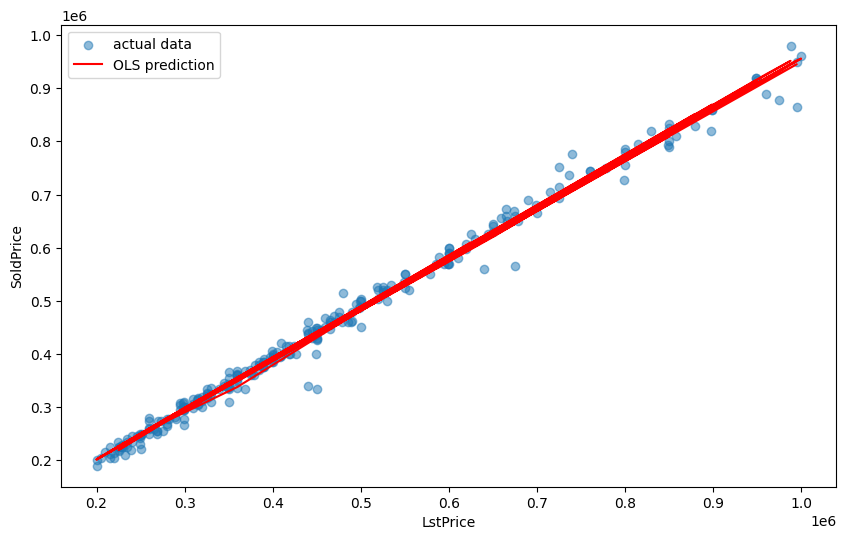

In [51]:
y_pred = model.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(df['LstPrice'], df['SoldPrice'], alpha=0.5, label='actual data')
plt.plot(df['LstPrice'], y_pred, color='red', label='OLS prediction') 
plt.xlabel('LstPrice')
plt.ylabel('SoldPrice')
plt.legend()
plt.show()

### Task 6: Multilinear Regression 

Develop a multilinear regression model for house prices in this neighborhood. We could use this to come up with a list price for houses coming on the market, so do not include the list price in your model and, for now, ignore the categorical variable Prop_Type. Your model should be of the form:

`Sold Price = beta_0 + beta_1 * x_1 + beta_2 * x_2 + ... +  beta_n * x_n `

where x_i are predictive variables. Which variables are the best predictors for the Sold Price? 

Specific questions:

+ Often the price per square foot for a house is advertised. Is this what the coefficient for TotSqf is measuring? Provide an interpretation for the coefficient for TotSqf.  
+ Estimate the value that each Garage space adds to a house. 
+ Does latitude or longitude have an impact on house price? Explain. 
+ If we wanted to start a 'house flipping' company, we'd have to be able to do a better job of predicting the sold price than the list price does. How does your model compare? 




In [52]:

features = ['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude',
            'Patio', 'PkgSpacs', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']


X = df[features]
X = sm.add_constant(X)  
y = df['SoldPrice']

model_multi = sm.OLS(y, X).fit()
print(model_multi.summary())

                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     86.78
Date:                Sat, 31 May 2025   Prob (F-statistic):           2.40e-81
Time:                        22:17:38   Log-Likelihood:                -3311.1
No. Observations:                 260   AIC:                             6648.
Df Residuals:                     247   BIC:                             6694.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.454e+08   5.62e+07      4.367      0.0

a1:  
No, the coefficient for TotSqf is not the exact price per square foot. It measures the average increase in the sold price for each additional square foot of total area, holding all other variables constant.

  
a2:  
GaragCap coefficient = 34,170. p-value = 0.000, very statistically significant
Each additional garage space is associated with an increase of approximately $34,170 in the sold price of a house, assuming all other variables are held constant.

  
a3:  
Longitude has a significant effect on sold price. A 1-unit increase in longitude (which is a big spatial change) is associated with a $2.68M increase in price.
Latitude is not statistically significant (p > 0.05), meaning we cannot confidently say it impacts sold price based on this data.

  
a4:  
multiple regression model (R² = 0.808) performs better than the simple model using only LstPrice (R² = 0.735).
This suggests that adding variables like square footage, garage spaces, etc., helps the model better predict sold price

### Task 7: Incorporating a categorical variable

Above, we considered houses, townhouses, and condos together, but here we'll distinguish between them. Consider the two regression models: 

`SoldPrice = beta_0 + beta_1 * Prop_Type_num`

and 

`SoldPrice = beta_0  + beta_1 * Prop_Type_num + beta_2 * TotSqf`

From the first model, it would appear that Property type is significant in predicting the sold price. On the other hand, the second model indicates that when you take into account total square footage, property type is no longer predictive. Explain this. (Hint: there is a confounder lurking here.) Make a scatterplot of TotSqf vs. SoldPrice where the house types are colored differently to illustrate your explanation. 


                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     46.99
Date:                Sun, 01 Jun 2025   Prob (F-statistic):           5.24e-11
Time:                        12:35:40   Log-Likelihood:                -3504.0
No. Observations:                 260   AIC:                             7012.
Df Residuals:                     258   BIC:                             7019.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     3.21e+05   2.15e+04     14.944      

/Users/jiagao/Desktop/6017/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jiagao/Desktop/6017/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


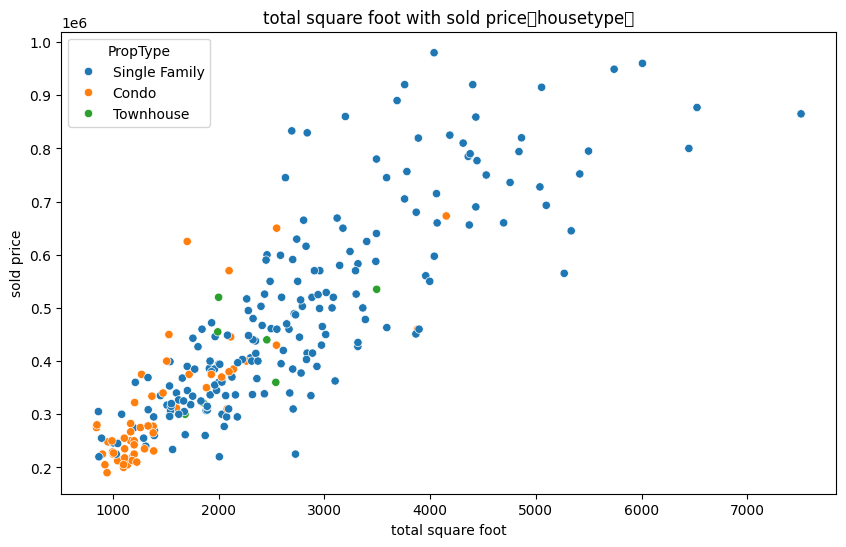

In [55]:
import statsmodels.formula.api as smf
model1 = smf.ols('SoldPrice ~ propTypeNum', data=df).fit()
print(model1.summary())

model2 = smf.ols('SoldPrice ~ propTypeNum + TotSqf', data=df).fit()
print(model2.summary())

plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotSqf', y='SoldPrice', hue='PropType', data=df)
plt.title('total square foot with sold price（housetype）')
plt.xlabel('total square foot')
plt.ylabel('sold price')
plt.show()

PropTypeNum looks predictive at first because property type is confounded with square footage.
Once add TotSqf, the true cause of price difference becomes clear, and property type loses its predictive power.
The plot shows property type groups tend to differ in size, and size explains most of the price differences.


